# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

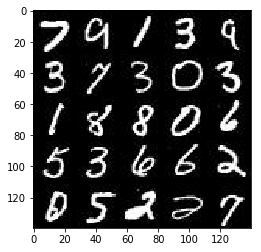

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

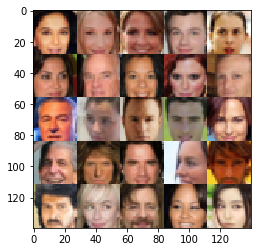

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):         
        # Hidden layer 1
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="SAME",
                              kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        lrelu1 = tf.maximum(alpha * h1, h1)
        # 14x14x64 now
        
        # Hidden Layer 2
        h2 = tf.layers.conv2d(lrelu1, 128, 5, strides=1, padding="SAME",
                              kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(h2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x128 now
        
        # Hidden Layer 3
        h3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding="SAME", 
                             kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(h3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        #7x7x256 now
        
        flat = tf.reshape(lrelu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        h1 = tf.layers.dense(z, 7*7*256)
        
        # Reshape it to start the convolutional stack
        h1 = tf.reshape(h1, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(h1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        # 4x4x256 now
        
        # Hidden Layer 2
        h2 = tf.layers.conv2d_transpose(lrelu1, 128, 5, strides=1, padding="SAME")
        bn2 = tf.layers.batch_normalization(h2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128 now
        
        # Hidden Layer 3
        h3 = tf.layers.conv2d_transpose(lrelu2, 64, 5, strides=2, padding='SAME')
        bn3 = tf.layers.batch_normalization(h3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # 16x16x64
        
        # Output layer, 28x28x5
        logits = tf.layers.conv2d_transpose(lrelu3, out_channel_dim, 5, strides=2, padding="SAME")
        
        out = tf.tanh(logits)        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    smooth = 0.1

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # Set the image width, height, and image channels
    _, image_width, image_height, image_channels = data_shape
    
    # Impliment model_inputs and set the input_real, input_z, and learning rate
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Impliment model_loss and set the d_loss and g_loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Impliment model_opt and set d_train_opt and g_train_opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Set batch counter
    batch_count = 0
    
    # Set number of images to print
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Multiply batch_images by 2.0 since the dataset ranges from -0.5 to 0.5
                batch_images = batch_images*2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                # Increment the batch_count
                batch_count += 1

                # Print the d_train_loss and g_train_loss every 10 batches
                if (batch_count % 10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                    
                # Print the generator output every 100 batches
                if (batch_count % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)  

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8263... Generator Loss: 1.1004
Epoch 1/2... Discriminator Loss: 3.0102... Generator Loss: 0.1070
Epoch 1/2... Discriminator Loss: 1.9719... Generator Loss: 0.3408
Epoch 1/2... Discriminator Loss: 0.6500... Generator Loss: 3.1859
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 0.6537
Epoch 1/2... Discriminator Loss: 0.9997... Generator Loss: 1.2777
Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 0.6850
Epoch 1/2... Discriminator Loss: 0.6599... Generator Loss: 2.1417
Epoch 1/2... Discriminator Loss: 0.7577... Generator Loss: 3.1186
Epoch 1/2... Discriminator Loss: 1.3809... Generator Loss: 0.6514


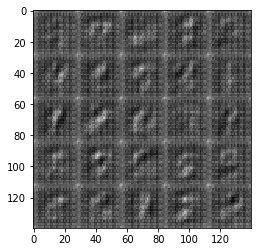

Epoch 1/2... Discriminator Loss: 0.8627... Generator Loss: 1.1929
Epoch 1/2... Discriminator Loss: 0.8620... Generator Loss: 2.3543
Epoch 1/2... Discriminator Loss: 0.7863... Generator Loss: 1.6506
Epoch 1/2... Discriminator Loss: 0.8281... Generator Loss: 1.3268
Epoch 1/2... Discriminator Loss: 0.7841... Generator Loss: 1.2156
Epoch 1/2... Discriminator Loss: 1.0099... Generator Loss: 2.8528
Epoch 1/2... Discriminator Loss: 0.8858... Generator Loss: 1.0126
Epoch 1/2... Discriminator Loss: 1.1285... Generator Loss: 0.7024
Epoch 1/2... Discriminator Loss: 0.8758... Generator Loss: 2.6882
Epoch 1/2... Discriminator Loss: 0.7633... Generator Loss: 2.1257


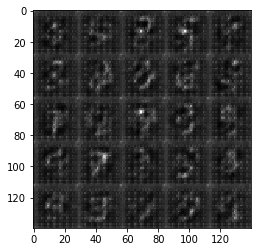

Epoch 1/2... Discriminator Loss: 0.6936... Generator Loss: 1.5265
Epoch 1/2... Discriminator Loss: 1.1738... Generator Loss: 3.4044
Epoch 1/2... Discriminator Loss: 1.3075... Generator Loss: 0.5459
Epoch 1/2... Discriminator Loss: 1.0205... Generator Loss: 0.8243
Epoch 1/2... Discriminator Loss: 0.8364... Generator Loss: 1.0241
Epoch 1/2... Discriminator Loss: 0.8205... Generator Loss: 2.3270
Epoch 1/2... Discriminator Loss: 0.5936... Generator Loss: 2.1741
Epoch 1/2... Discriminator Loss: 1.8473... Generator Loss: 4.5523
Epoch 1/2... Discriminator Loss: 0.6764... Generator Loss: 1.5620
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 3.5205


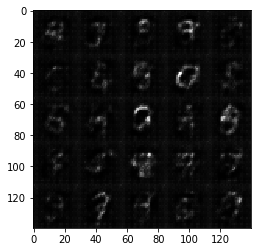

Epoch 1/2... Discriminator Loss: 0.6756... Generator Loss: 1.4176
Epoch 1/2... Discriminator Loss: 0.7907... Generator Loss: 1.1309
Epoch 1/2... Discriminator Loss: 0.6238... Generator Loss: 1.9737
Epoch 1/2... Discriminator Loss: 0.8418... Generator Loss: 1.1653
Epoch 1/2... Discriminator Loss: 0.7756... Generator Loss: 1.1771
Epoch 1/2... Discriminator Loss: 0.6379... Generator Loss: 1.5953
Epoch 1/2... Discriminator Loss: 0.7101... Generator Loss: 2.8500
Epoch 1/2... Discriminator Loss: 0.6357... Generator Loss: 2.2348
Epoch 1/2... Discriminator Loss: 0.7866... Generator Loss: 2.8852
Epoch 1/2... Discriminator Loss: 0.8406... Generator Loss: 1.0348


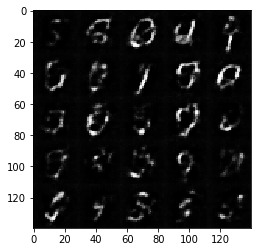

Epoch 1/2... Discriminator Loss: 0.8873... Generator Loss: 2.9563
Epoch 1/2... Discriminator Loss: 0.7076... Generator Loss: 1.5130
Epoch 1/2... Discriminator Loss: 0.8009... Generator Loss: 1.1528
Epoch 1/2... Discriminator Loss: 0.6480... Generator Loss: 1.6047
Epoch 1/2... Discriminator Loss: 0.7636... Generator Loss: 1.1749
Epoch 1/2... Discriminator Loss: 0.7260... Generator Loss: 1.4124
Epoch 1/2... Discriminator Loss: 1.0621... Generator Loss: 3.5895
Epoch 1/2... Discriminator Loss: 0.7354... Generator Loss: 1.8595
Epoch 1/2... Discriminator Loss: 0.6678... Generator Loss: 2.3415
Epoch 1/2... Discriminator Loss: 0.6403... Generator Loss: 1.8324


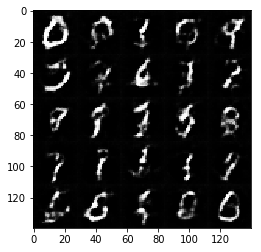

Epoch 1/2... Discriminator Loss: 0.6961... Generator Loss: 1.5424
Epoch 1/2... Discriminator Loss: 0.7185... Generator Loss: 2.4919
Epoch 1/2... Discriminator Loss: 0.7131... Generator Loss: 2.3757
Epoch 1/2... Discriminator Loss: 0.7177... Generator Loss: 1.3718
Epoch 1/2... Discriminator Loss: 1.1969... Generator Loss: 1.8191
Epoch 1/2... Discriminator Loss: 1.0235... Generator Loss: 0.9371
Epoch 1/2... Discriminator Loss: 0.7676... Generator Loss: 1.7814
Epoch 1/2... Discriminator Loss: 0.6802... Generator Loss: 1.6141
Epoch 1/2... Discriminator Loss: 0.8876... Generator Loss: 1.0373
Epoch 1/2... Discriminator Loss: 0.7754... Generator Loss: 1.1805


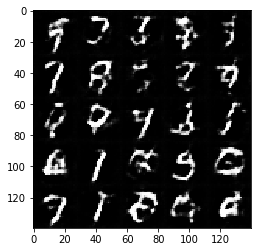

Epoch 1/2... Discriminator Loss: 0.6866... Generator Loss: 1.7518
Epoch 1/2... Discriminator Loss: 0.6874... Generator Loss: 1.6517
Epoch 1/2... Discriminator Loss: 0.7085... Generator Loss: 1.3823
Epoch 1/2... Discriminator Loss: 0.6330... Generator Loss: 1.6943
Epoch 1/2... Discriminator Loss: 0.8523... Generator Loss: 1.1017
Epoch 1/2... Discriminator Loss: 1.4902... Generator Loss: 0.5001
Epoch 1/2... Discriminator Loss: 0.7961... Generator Loss: 1.3664
Epoch 1/2... Discriminator Loss: 0.7508... Generator Loss: 1.5266
Epoch 1/2... Discriminator Loss: 0.8048... Generator Loss: 1.2797
Epoch 1/2... Discriminator Loss: 0.7322... Generator Loss: 1.5013


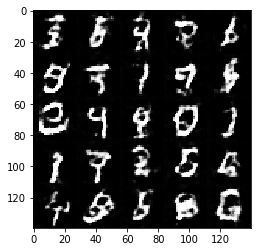

Epoch 1/2... Discriminator Loss: 1.0213... Generator Loss: 0.7835
Epoch 1/2... Discriminator Loss: 0.7145... Generator Loss: 1.6708
Epoch 1/2... Discriminator Loss: 0.7770... Generator Loss: 1.2511
Epoch 1/2... Discriminator Loss: 6.2609... Generator Loss: 8.1958
Epoch 1/2... Discriminator Loss: 0.9496... Generator Loss: 0.9595
Epoch 1/2... Discriminator Loss: 0.8684... Generator Loss: 1.1246
Epoch 1/2... Discriminator Loss: 0.7675... Generator Loss: 1.4032
Epoch 1/2... Discriminator Loss: 0.6702... Generator Loss: 1.7756
Epoch 1/2... Discriminator Loss: 0.9507... Generator Loss: 0.9298
Epoch 1/2... Discriminator Loss: 0.8096... Generator Loss: 1.6970


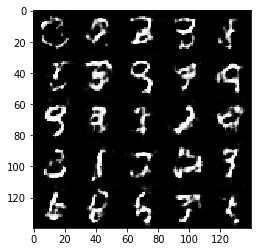

Epoch 1/2... Discriminator Loss: 1.5630... Generator Loss: 3.7163
Epoch 1/2... Discriminator Loss: 0.9222... Generator Loss: 1.5803
Epoch 1/2... Discriminator Loss: 0.8586... Generator Loss: 1.2049
Epoch 1/2... Discriminator Loss: 0.7066... Generator Loss: 1.6483
Epoch 1/2... Discriminator Loss: 0.6715... Generator Loss: 1.7307
Epoch 1/2... Discriminator Loss: 0.7558... Generator Loss: 1.3419
Epoch 1/2... Discriminator Loss: 0.6771... Generator Loss: 1.8540
Epoch 1/2... Discriminator Loss: 1.9989... Generator Loss: 4.4141
Epoch 1/2... Discriminator Loss: 0.8323... Generator Loss: 1.5193
Epoch 1/2... Discriminator Loss: 0.7148... Generator Loss: 1.4535


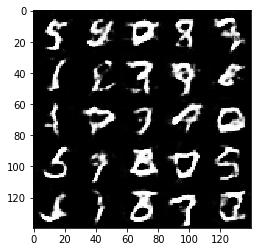

Epoch 1/2... Discriminator Loss: 0.8045... Generator Loss: 1.1958
Epoch 1/2... Discriminator Loss: 0.6518... Generator Loss: 1.6042
Epoch 1/2... Discriminator Loss: 0.6604... Generator Loss: 1.4655
Epoch 2/2... Discriminator Loss: 0.8331... Generator Loss: 1.1000
Epoch 2/2... Discriminator Loss: 0.6772... Generator Loss: 1.6029
Epoch 2/2... Discriminator Loss: 0.6808... Generator Loss: 1.8916
Epoch 2/2... Discriminator Loss: 0.9044... Generator Loss: 1.3432
Epoch 2/2... Discriminator Loss: 0.7661... Generator Loss: 2.0229
Epoch 2/2... Discriminator Loss: 0.8101... Generator Loss: 1.2022
Epoch 2/2... Discriminator Loss: 1.1106... Generator Loss: 0.7312


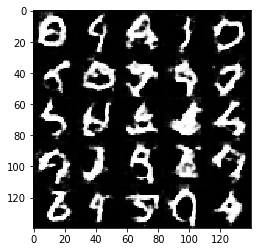

Epoch 2/2... Discriminator Loss: 0.6835... Generator Loss: 1.5218
Epoch 2/2... Discriminator Loss: 0.8359... Generator Loss: 1.1696
Epoch 2/2... Discriminator Loss: 1.6544... Generator Loss: 3.4228
Epoch 2/2... Discriminator Loss: 0.7581... Generator Loss: 1.2379
Epoch 2/2... Discriminator Loss: 0.8539... Generator Loss: 1.0610
Epoch 2/2... Discriminator Loss: 0.7545... Generator Loss: 1.2329
Epoch 2/2... Discriminator Loss: 0.7687... Generator Loss: 1.5019
Epoch 2/2... Discriminator Loss: 1.9092... Generator Loss: 0.3135
Epoch 2/2... Discriminator Loss: 1.6333... Generator Loss: 0.4096
Epoch 2/2... Discriminator Loss: 1.0808... Generator Loss: 0.7705


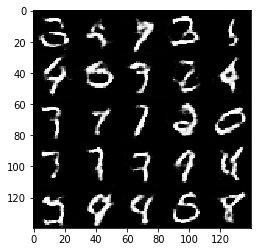

Epoch 2/2... Discriminator Loss: 0.6168... Generator Loss: 1.6963
Epoch 2/2... Discriminator Loss: 0.7389... Generator Loss: 1.2622
Epoch 2/2... Discriminator Loss: 0.8398... Generator Loss: 1.0092
Epoch 2/2... Discriminator Loss: 1.4977... Generator Loss: 0.4481
Epoch 2/2... Discriminator Loss: 0.8114... Generator Loss: 2.2925
Epoch 2/2... Discriminator Loss: 1.2543... Generator Loss: 2.3705
Epoch 2/2... Discriminator Loss: 0.9505... Generator Loss: 1.7587
Epoch 2/2... Discriminator Loss: 1.0833... Generator Loss: 1.3197
Epoch 2/2... Discriminator Loss: 0.7920... Generator Loss: 1.9010
Epoch 2/2... Discriminator Loss: 0.7643... Generator Loss: 1.2055


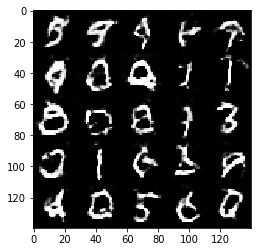

Epoch 2/2... Discriminator Loss: 0.9838... Generator Loss: 0.8260
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 0.8600
Epoch 2/2... Discriminator Loss: 0.7978... Generator Loss: 1.1351
Epoch 2/2... Discriminator Loss: 1.7338... Generator Loss: 0.3870
Epoch 2/2... Discriminator Loss: 1.0880... Generator Loss: 0.8384
Epoch 2/2... Discriminator Loss: 0.8830... Generator Loss: 1.4823
Epoch 2/2... Discriminator Loss: 1.0664... Generator Loss: 0.7728
Epoch 2/2... Discriminator Loss: 0.8010... Generator Loss: 1.6333
Epoch 2/2... Discriminator Loss: 1.3047... Generator Loss: 0.5966
Epoch 2/2... Discriminator Loss: 1.0830... Generator Loss: 0.7630


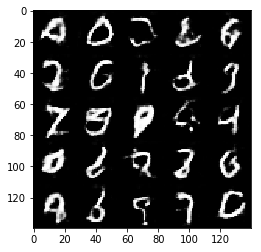

Epoch 2/2... Discriminator Loss: 0.7106... Generator Loss: 1.5317
Epoch 2/2... Discriminator Loss: 0.6645... Generator Loss: 1.5800
Epoch 2/2... Discriminator Loss: 0.5990... Generator Loss: 1.7800
Epoch 2/2... Discriminator Loss: 0.7373... Generator Loss: 1.3242
Epoch 2/2... Discriminator Loss: 1.4485... Generator Loss: 0.5518
Epoch 2/2... Discriminator Loss: 1.0050... Generator Loss: 0.8852
Epoch 2/2... Discriminator Loss: 0.8187... Generator Loss: 1.9417
Epoch 2/2... Discriminator Loss: 0.9275... Generator Loss: 0.9666
Epoch 2/2... Discriminator Loss: 0.9887... Generator Loss: 2.6291
Epoch 2/2... Discriminator Loss: 1.4479... Generator Loss: 0.4899


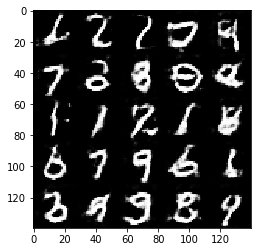

Epoch 2/2... Discriminator Loss: 0.6009... Generator Loss: 1.9356
Epoch 2/2... Discriminator Loss: 0.6913... Generator Loss: 1.5656
Epoch 2/2... Discriminator Loss: 0.8767... Generator Loss: 1.1972
Epoch 2/2... Discriminator Loss: 1.1856... Generator Loss: 0.6872
Epoch 2/2... Discriminator Loss: 0.8052... Generator Loss: 1.6768
Epoch 2/2... Discriminator Loss: 0.7008... Generator Loss: 1.4976
Epoch 2/2... Discriminator Loss: 0.7991... Generator Loss: 1.2358
Epoch 2/2... Discriminator Loss: 0.7269... Generator Loss: 1.3868
Epoch 2/2... Discriminator Loss: 0.9264... Generator Loss: 1.2447
Epoch 2/2... Discriminator Loss: 1.3037... Generator Loss: 0.5962


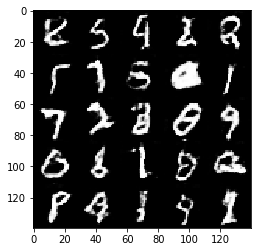

Epoch 2/2... Discriminator Loss: 1.3933... Generator Loss: 0.5544
Epoch 2/2... Discriminator Loss: 0.9049... Generator Loss: 1.0033
Epoch 2/2... Discriminator Loss: 0.8951... Generator Loss: 0.9737
Epoch 2/2... Discriminator Loss: 0.8235... Generator Loss: 1.1051
Epoch 2/2... Discriminator Loss: 0.8522... Generator Loss: 1.0435
Epoch 2/2... Discriminator Loss: 0.8748... Generator Loss: 1.0207
Epoch 2/2... Discriminator Loss: 0.7036... Generator Loss: 1.4000
Epoch 2/2... Discriminator Loss: 0.6571... Generator Loss: 1.7144
Epoch 2/2... Discriminator Loss: 0.8147... Generator Loss: 1.2338
Epoch 2/2... Discriminator Loss: 0.7077... Generator Loss: 1.5468


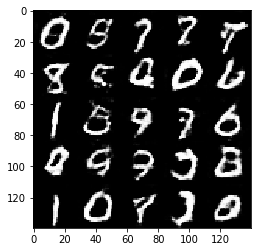

Epoch 2/2... Discriminator Loss: 1.0611... Generator Loss: 1.4126
Epoch 2/2... Discriminator Loss: 1.2690... Generator Loss: 0.6307
Epoch 2/2... Discriminator Loss: 0.8156... Generator Loss: 1.7802
Epoch 2/2... Discriminator Loss: 0.7232... Generator Loss: 1.9071
Epoch 2/2... Discriminator Loss: 0.9593... Generator Loss: 0.9626
Epoch 2/2... Discriminator Loss: 0.7256... Generator Loss: 1.5393
Epoch 2/2... Discriminator Loss: 0.8443... Generator Loss: 1.0601
Epoch 2/2... Discriminator Loss: 0.6783... Generator Loss: 1.5150
Epoch 2/2... Discriminator Loss: 0.7247... Generator Loss: 1.4636
Epoch 2/2... Discriminator Loss: 0.9858... Generator Loss: 0.9099


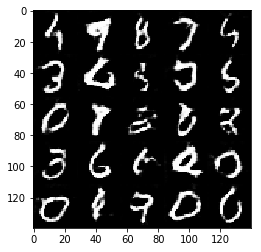

Epoch 2/2... Discriminator Loss: 0.7692... Generator Loss: 1.2258
Epoch 2/2... Discriminator Loss: 0.6172... Generator Loss: 1.9217
Epoch 2/2... Discriminator Loss: 1.2307... Generator Loss: 3.2022
Epoch 2/2... Discriminator Loss: 0.6668... Generator Loss: 1.5977
Epoch 2/2... Discriminator Loss: 0.7356... Generator Loss: 1.3622
Epoch 2/2... Discriminator Loss: 0.7015... Generator Loss: 1.6373
Epoch 2/2... Discriminator Loss: 0.7469... Generator Loss: 1.5596
Epoch 2/2... Discriminator Loss: 0.7693... Generator Loss: 1.2208
Epoch 2/2... Discriminator Loss: 0.7459... Generator Loss: 1.3562
Epoch 2/2... Discriminator Loss: 1.4014... Generator Loss: 0.5788


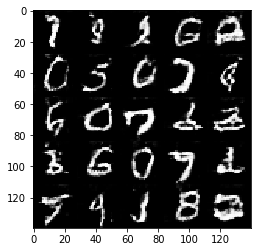

Epoch 2/2... Discriminator Loss: 0.7771... Generator Loss: 2.0112
Epoch 2/2... Discriminator Loss: 0.8473... Generator Loss: 1.1435
Epoch 2/2... Discriminator Loss: 0.7741... Generator Loss: 1.4314
Epoch 2/2... Discriminator Loss: 1.0384... Generator Loss: 0.7649
Epoch 2/2... Discriminator Loss: 0.9960... Generator Loss: 0.8869
Epoch 2/2... Discriminator Loss: 1.7786... Generator Loss: 0.4659
Epoch 2/2... Discriminator Loss: 0.7154... Generator Loss: 1.5350


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 0.6429... Generator Loss: 1.7302
Epoch 1/1... Discriminator Loss: 0.7685... Generator Loss: 1.5174
Epoch 1/1... Discriminator Loss: 0.5235... Generator Loss: 3.7281
Epoch 1/1... Discriminator Loss: 0.6167... Generator Loss: 3.5975
Epoch 1/1... Discriminator Loss: 1.6397... Generator Loss: 0.4594
Epoch 1/1... Discriminator Loss: 1.8714... Generator Loss: 0.4430
Epoch 1/1... Discriminator Loss: 0.9070... Generator Loss: 1.7072
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 1.4807
Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 1.0881


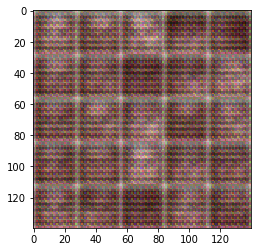

Epoch 1/1... Discriminator Loss: 0.6885... Generator Loss: 3.3945
Epoch 1/1... Discriminator Loss: 0.6380... Generator Loss: 3.3351
Epoch 1/1... Discriminator Loss: 0.5356... Generator Loss: 2.4893
Epoch 1/1... Discriminator Loss: 0.5379... Generator Loss: 2.7826
Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 1.4043
Epoch 1/1... Discriminator Loss: 0.5396... Generator Loss: 3.1072
Epoch 1/1... Discriminator Loss: 0.8261... Generator Loss: 1.3753
Epoch 1/1... Discriminator Loss: 0.7075... Generator Loss: 1.7402
Epoch 1/1... Discriminator Loss: 0.5725... Generator Loss: 2.2748
Epoch 1/1... Discriminator Loss: 0.6467... Generator Loss: 2.8125


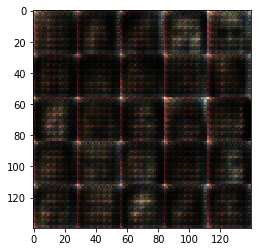

Epoch 1/1... Discriminator Loss: 0.5989... Generator Loss: 2.6283
Epoch 1/1... Discriminator Loss: 0.7310... Generator Loss: 1.5449
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 1.2780
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 3.2376
Epoch 1/1... Discriminator Loss: 0.7696... Generator Loss: 1.9827
Epoch 1/1... Discriminator Loss: 0.8599... Generator Loss: 1.2409
Epoch 1/1... Discriminator Loss: 0.8605... Generator Loss: 1.1716
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 0.7457... Generator Loss: 1.8009
Epoch 1/1... Discriminator Loss: 0.8140... Generator Loss: 1.5041


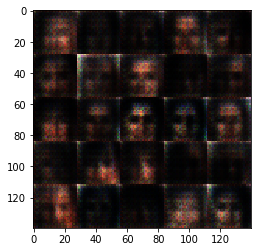

Epoch 1/1... Discriminator Loss: 2.1689... Generator Loss: 5.1311
Epoch 1/1... Discriminator Loss: 0.8128... Generator Loss: 1.6479
Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 1.0155
Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 1.6198
Epoch 1/1... Discriminator Loss: 0.8130... Generator Loss: 2.3357
Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 2.7327
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 0.7794... Generator Loss: 1.9220
Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 2.3517
Epoch 1/1... Discriminator Loss: 1.7098... Generator Loss: 0.3880


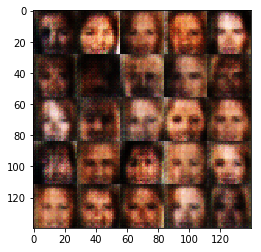

Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 0.8452... Generator Loss: 1.4252
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 1.2561
Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.0864
Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 1.1587
Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 1.1069
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.4279


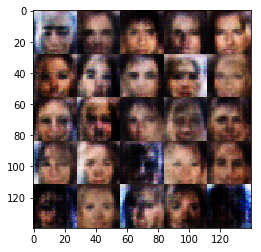

Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 1.3195
Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 1.5582
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 2.0670
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.4716
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 1.1526
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 0.9150... Generator Loss: 1.2596
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 2.1147
Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 2.2404


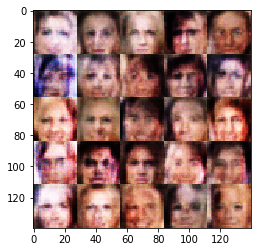

Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 1.0942
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 1.4440
Epoch 1/1... Discriminator Loss: 0.9883... Generator Loss: 1.0138
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.4732
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 1.5445
Epoch 1/1... Discriminator Loss: 2.1132... Generator Loss: 3.5028
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 1.0216
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 1.5089


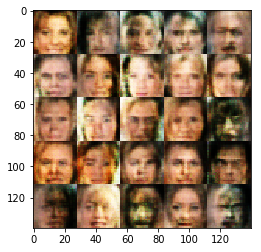

Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 2.4414
Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 1.1001
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 2.4400
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 1.6862
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 1.0727
Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 1.0349
Epoch 1/1... Discriminator Loss: 0.9435... Generator Loss: 1.2824
Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 2.2565
Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 1.5080
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 2.5758


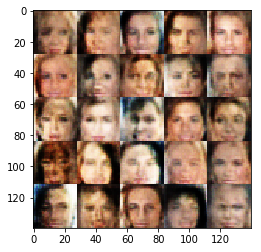

Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 1.5315
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 0.8128... Generator Loss: 1.5601
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 2.3395
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 1.0754
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 1.9764


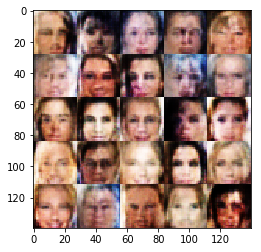

Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 1.7378
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 1.1371
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 1.6097
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.5727... Generator Loss: 0.4691
Epoch 1/1... Discriminator Loss: 0.9185... Generator Loss: 1.2666


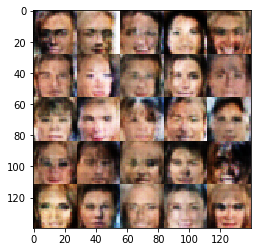

Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 1.0852
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 1.7534
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.6945... Generator Loss: 0.3749
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 1.4822
Epoch 1/1... Discriminator Loss: 0.7757... Generator Loss: 1.5453
Epoch 1/1... Discriminator Loss: 1.5474... Generator Loss: 0.4279
Epoch 1/1... Discriminator Loss: 0.9685... Generator Loss: 1.4741
Epoch 1/1... Discriminator Loss: 0.8268... Generator Loss: 1.2587


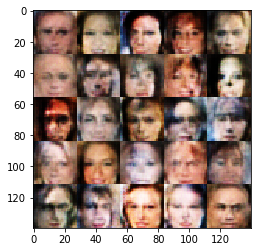

Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 2.0460
Epoch 1/1... Discriminator Loss: 0.7211... Generator Loss: 1.5306
Epoch 1/1... Discriminator Loss: 0.6947... Generator Loss: 4.2079
Epoch 1/1... Discriminator Loss: 0.5531... Generator Loss: 2.1494
Epoch 1/1... Discriminator Loss: 0.8300... Generator Loss: 1.3205
Epoch 1/1... Discriminator Loss: 0.8006... Generator Loss: 2.4703
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 0.7180... Generator Loss: 1.3515
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 3.5030
Epoch 1/1... Discriminator Loss: 0.8492... Generator Loss: 1.3404


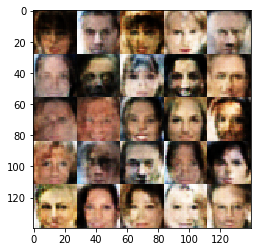

Epoch 1/1... Discriminator Loss: 0.7888... Generator Loss: 1.2333
Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 1.4830
Epoch 1/1... Discriminator Loss: 0.7781... Generator Loss: 1.1547
Epoch 1/1... Discriminator Loss: 0.8679... Generator Loss: 1.1445
Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.4782
Epoch 1/1... Discriminator Loss: 0.8435... Generator Loss: 1.0964
Epoch 1/1... Discriminator Loss: 0.7599... Generator Loss: 1.3283
Epoch 1/1... Discriminator Loss: 0.6179... Generator Loss: 1.7251
Epoch 1/1... Discriminator Loss: 0.6976... Generator Loss: 2.0670


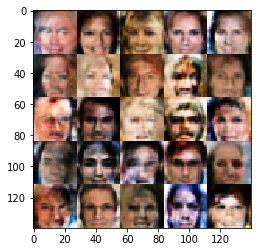

Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 1.4337
Epoch 1/1... Discriminator Loss: 2.0875... Generator Loss: 0.2537
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 1.3252
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 1.4123
Epoch 1/1... Discriminator Loss: 0.6581... Generator Loss: 2.9480
Epoch 1/1... Discriminator Loss: 0.8556... Generator Loss: 1.1019
Epoch 1/1... Discriminator Loss: 0.5679... Generator Loss: 1.9810
Epoch 1/1... Discriminator Loss: 0.4189... Generator Loss: 3.5178
Epoch 1/1... Discriminator Loss: 2.5314... Generator Loss: 0.1895
Epoch 1/1... Discriminator Loss: 0.8358... Generator Loss: 1.1375


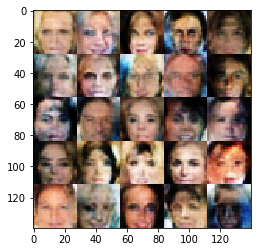

Epoch 1/1... Discriminator Loss: 0.6404... Generator Loss: 1.9454
Epoch 1/1... Discriminator Loss: 0.7621... Generator Loss: 1.3292
Epoch 1/1... Discriminator Loss: 0.7385... Generator Loss: 1.2866
Epoch 1/1... Discriminator Loss: 0.5524... Generator Loss: 2.2394
Epoch 1/1... Discriminator Loss: 0.4772... Generator Loss: 2.7533
Epoch 1/1... Discriminator Loss: 0.7381... Generator Loss: 1.3504
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 1.3547
Epoch 1/1... Discriminator Loss: 0.8322... Generator Loss: 1.9601
Epoch 1/1... Discriminator Loss: 0.6517... Generator Loss: 2.6858


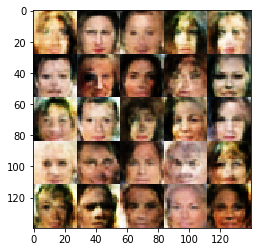

Epoch 1/1... Discriminator Loss: 0.6653... Generator Loss: 1.4984
Epoch 1/1... Discriminator Loss: 0.4590... Generator Loss: 2.6036
Epoch 1/1... Discriminator Loss: 0.6079... Generator Loss: 1.8243
Epoch 1/1... Discriminator Loss: 0.6397... Generator Loss: 2.0862
Epoch 1/1... Discriminator Loss: 0.6326... Generator Loss: 2.0162
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 2.7514
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 3.3952
Epoch 1/1... Discriminator Loss: 0.7341... Generator Loss: 1.7217
Epoch 1/1... Discriminator Loss: 0.6149... Generator Loss: 1.7721


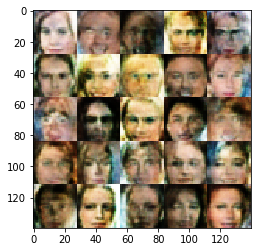

Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 1.2758
Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 1.9020
Epoch 1/1... Discriminator Loss: 0.6382... Generator Loss: 1.9906
Epoch 1/1... Discriminator Loss: 1.9395... Generator Loss: 0.2892
Epoch 1/1... Discriminator Loss: 0.5629... Generator Loss: 2.1103
Epoch 1/1... Discriminator Loss: 0.8580... Generator Loss: 1.0978
Epoch 1/1... Discriminator Loss: 0.5694... Generator Loss: 2.5749
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 3.8692
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 1.8055
Epoch 1/1... Discriminator Loss: 0.5475... Generator Loss: 2.2389


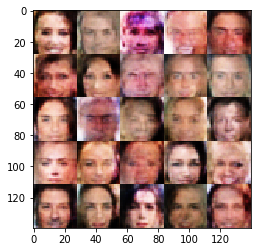

Epoch 1/1... Discriminator Loss: 0.7592... Generator Loss: 3.3003
Epoch 1/1... Discriminator Loss: 0.5374... Generator Loss: 2.1058
Epoch 1/1... Discriminator Loss: 0.4494... Generator Loss: 3.2410
Epoch 1/1... Discriminator Loss: 0.4453... Generator Loss: 3.1227
Epoch 1/1... Discriminator Loss: 0.5301... Generator Loss: 2.1818
Epoch 1/1... Discriminator Loss: 0.4684... Generator Loss: 2.6078
Epoch 1/1... Discriminator Loss: 0.4693... Generator Loss: 3.3546
Epoch 1/1... Discriminator Loss: 0.7573... Generator Loss: 1.3046
Epoch 1/1... Discriminator Loss: 0.4703... Generator Loss: 2.5049
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 4.7130


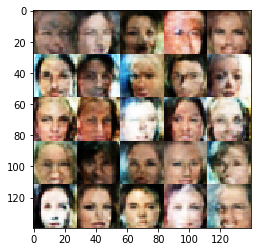

Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 3.1968
Epoch 1/1... Discriminator Loss: 0.8548... Generator Loss: 3.5838
Epoch 1/1... Discriminator Loss: 0.7530... Generator Loss: 1.5170
Epoch 1/1... Discriminator Loss: 0.5331... Generator Loss: 3.2699
Epoch 1/1... Discriminator Loss: 0.6742... Generator Loss: 1.5841
Epoch 1/1... Discriminator Loss: 0.4298... Generator Loss: 2.9555
Epoch 1/1... Discriminator Loss: 0.8349... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 0.7117... Generator Loss: 1.3072
Epoch 1/1... Discriminator Loss: 0.4565... Generator Loss: 2.8277
Epoch 1/1... Discriminator Loss: 0.7708... Generator Loss: 1.2972


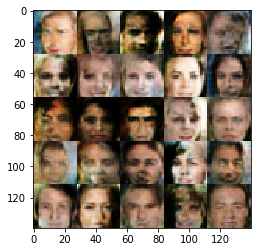

Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 3.6454
Epoch 1/1... Discriminator Loss: 0.7842... Generator Loss: 1.1661
Epoch 1/1... Discriminator Loss: 0.5757... Generator Loss: 1.7869
Epoch 1/1... Discriminator Loss: 0.4683... Generator Loss: 2.4555
Epoch 1/1... Discriminator Loss: 0.4485... Generator Loss: 2.7007
Epoch 1/1... Discriminator Loss: 0.6052... Generator Loss: 2.2514
Epoch 1/1... Discriminator Loss: 0.6337... Generator Loss: 2.4257
Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 1.2146
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 2.6369
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 1.8850


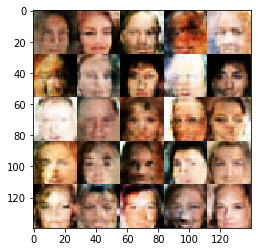

Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 1.4619
Epoch 1/1... Discriminator Loss: 0.7029... Generator Loss: 1.4508
Epoch 1/1... Discriminator Loss: 0.4539... Generator Loss: 2.6248
Epoch 1/1... Discriminator Loss: 0.6175... Generator Loss: 1.7927
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 0.7814... Generator Loss: 1.3942
Epoch 1/1... Discriminator Loss: 0.5789... Generator Loss: 1.7983
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 3.6624
Epoch 1/1... Discriminator Loss: 0.7581... Generator Loss: 1.3259
Epoch 1/1... Discriminator Loss: 0.8203... Generator Loss: 2.2418


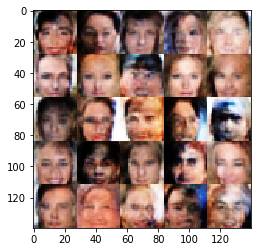

Epoch 1/1... Discriminator Loss: 0.6979... Generator Loss: 1.4750
Epoch 1/1... Discriminator Loss: 0.6574... Generator Loss: 2.4066
Epoch 1/1... Discriminator Loss: 0.5638... Generator Loss: 2.8113
Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 1.2221
Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 1.4956
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 2.5622
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 0.9497
Epoch 1/1... Discriminator Loss: 0.5379... Generator Loss: 2.9041
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 0.5844... Generator Loss: 1.9866


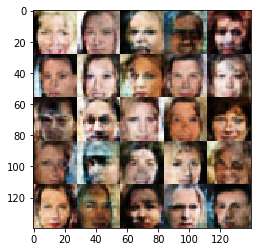

Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 0.7166... Generator Loss: 1.6561
Epoch 1/1... Discriminator Loss: 0.8462... Generator Loss: 1.2247
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 2.3083
Epoch 1/1... Discriminator Loss: 0.8806... Generator Loss: 1.0685
Epoch 1/1... Discriminator Loss: 0.5918... Generator Loss: 1.6767
Epoch 1/1... Discriminator Loss: 0.7256... Generator Loss: 1.3665
Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 1.3490
Epoch 1/1... Discriminator Loss: 0.7665... Generator Loss: 1.2724
Epoch 1/1... Discriminator Loss: 0.6306... Generator Loss: 1.6176


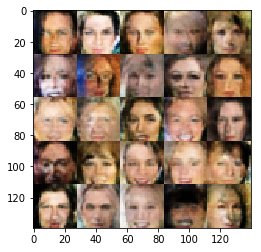

Epoch 1/1... Discriminator Loss: 0.5127... Generator Loss: 2.3186
Epoch 1/1... Discriminator Loss: 0.6778... Generator Loss: 2.2900
Epoch 1/1... Discriminator Loss: 0.5824... Generator Loss: 2.0565
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 0.6357... Generator Loss: 2.5888
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 0.8797... Generator Loss: 1.5700
Epoch 1/1... Discriminator Loss: 0.7075... Generator Loss: 2.3953
Epoch 1/1... Discriminator Loss: 0.4795... Generator Loss: 2.8498
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 1.5319


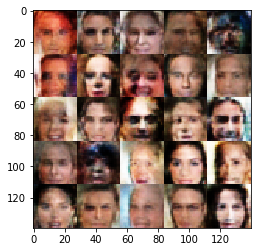

Epoch 1/1... Discriminator Loss: 0.8161... Generator Loss: 1.7963
Epoch 1/1... Discriminator Loss: 0.7954... Generator Loss: 1.8381
Epoch 1/1... Discriminator Loss: 0.7517... Generator Loss: 1.2474
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 0.7549... Generator Loss: 1.2460
Epoch 1/1... Discriminator Loss: 0.6092... Generator Loss: 2.1553
Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 1.3447
Epoch 1/1... Discriminator Loss: 0.5513... Generator Loss: 3.5800
Epoch 1/1... Discriminator Loss: 1.5368... Generator Loss: 0.4684
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.6458


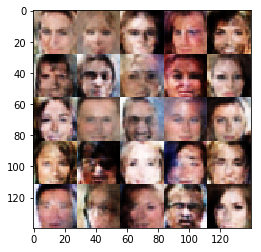

Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 1.0844
Epoch 1/1... Discriminator Loss: 0.8387... Generator Loss: 1.1519
Epoch 1/1... Discriminator Loss: 0.9057... Generator Loss: 1.1841
Epoch 1/1... Discriminator Loss: 0.5580... Generator Loss: 2.1986
Epoch 1/1... Discriminator Loss: 0.8053... Generator Loss: 1.3109
Epoch 1/1... Discriminator Loss: 0.7766... Generator Loss: 1.3140
Epoch 1/1... Discriminator Loss: 0.6508... Generator Loss: 1.4797
Epoch 1/1... Discriminator Loss: 0.7767... Generator Loss: 2.0605
Epoch 1/1... Discriminator Loss: 0.9673... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 0.7077... Generator Loss: 1.4531


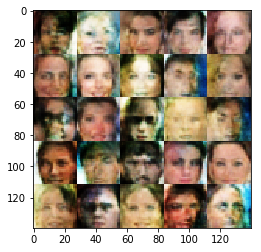

Epoch 1/1... Discriminator Loss: 0.8158... Generator Loss: 1.1120
Epoch 1/1... Discriminator Loss: 0.6155... Generator Loss: 3.0542
Epoch 1/1... Discriminator Loss: 0.7404... Generator Loss: 1.3643
Epoch 1/1... Discriminator Loss: 0.5226... Generator Loss: 2.3047
Epoch 1/1... Discriminator Loss: 0.8572... Generator Loss: 2.5717
Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 0.5590... Generator Loss: 2.1669
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 0.5747... Generator Loss: 2.2727
Epoch 1/1... Discriminator Loss: 0.6824... Generator Loss: 1.7837


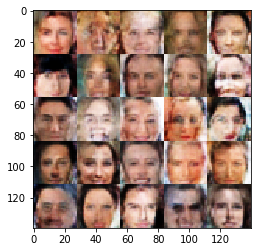

Epoch 1/1... Discriminator Loss: 0.7760... Generator Loss: 2.2120
Epoch 1/1... Discriminator Loss: 1.5134... Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 0.5858... Generator Loss: 2.0711
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 0.6602... Generator Loss: 1.6038
Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 1.5761
Epoch 1/1... Discriminator Loss: 0.7565... Generator Loss: 1.3716
Epoch 1/1... Discriminator Loss: 0.5625... Generator Loss: 2.3502
Epoch 1/1... Discriminator Loss: 0.7006... Generator Loss: 1.5141
Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 2.5733


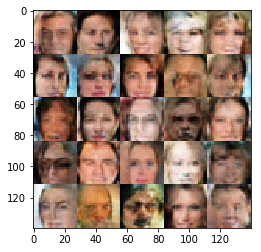

Epoch 1/1... Discriminator Loss: 0.9068... Generator Loss: 1.0157
Epoch 1/1... Discriminator Loss: 0.7359... Generator Loss: 3.4673
Epoch 1/1... Discriminator Loss: 0.6125... Generator Loss: 3.4850
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 2.8242
Epoch 1/1... Discriminator Loss: 0.8679... Generator Loss: 1.2138
Epoch 1/1... Discriminator Loss: 0.7809... Generator Loss: 1.2372
Epoch 1/1... Discriminator Loss: 0.6899... Generator Loss: 1.4804
Epoch 1/1... Discriminator Loss: 0.6679... Generator Loss: 1.5889
Epoch 1/1... Discriminator Loss: 0.4879... Generator Loss: 2.3016
Epoch 1/1... Discriminator Loss: 0.7364... Generator Loss: 2.3116


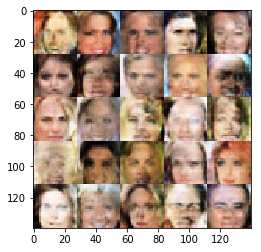

Epoch 1/1... Discriminator Loss: 0.7896... Generator Loss: 1.1774
Epoch 1/1... Discriminator Loss: 0.7718... Generator Loss: 1.3316
Epoch 1/1... Discriminator Loss: 0.5786... Generator Loss: 2.0614
Epoch 1/1... Discriminator Loss: 0.5429... Generator Loss: 2.2268
Epoch 1/1... Discriminator Loss: 0.5358... Generator Loss: 2.1417
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 2.7523
Epoch 1/1... Discriminator Loss: 0.7337... Generator Loss: 1.6473
Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 0.8817... Generator Loss: 1.0571


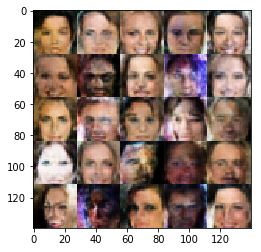

Epoch 1/1... Discriminator Loss: 0.4828... Generator Loss: 2.6916
Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 1.2449
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 0.9768
Epoch 1/1... Discriminator Loss: 0.5151... Generator Loss: 2.2982
Epoch 1/1... Discriminator Loss: 0.5400... Generator Loss: 2.3089
Epoch 1/1... Discriminator Loss: 2.1023... Generator Loss: 0.3026
Epoch 1/1... Discriminator Loss: 1.7702... Generator Loss: 2.2521
Epoch 1/1... Discriminator Loss: 0.5072... Generator Loss: 2.5750
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 0.6575... Generator Loss: 1.8952


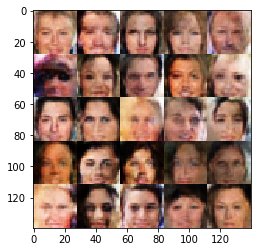

Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 0.4684... Generator Loss: 2.9007
Epoch 1/1... Discriminator Loss: 0.6231... Generator Loss: 1.6646
Epoch 1/1... Discriminator Loss: 0.5343... Generator Loss: 1.9955
Epoch 1/1... Discriminator Loss: 0.4735... Generator Loss: 2.3800
Epoch 1/1... Discriminator Loss: 0.5285... Generator Loss: 1.9715


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.